# Exective summary of Work Package 3

## Objectives

In this WP, you will work on a given training dataset. Your goal is to develop a fault detection model using the regression algorithms learnt in the class, in order to achieve best F1 score。

## Tasks

- Task 1: Develop a regression model to predict the reference value for motor temperature.
- Task 2: Develop a fault detection model using the regression model you developed in Task 1.

## Delierables

- A Jupyter notebook reporting the process and results of the above tasks


# Before starting, please:
- Fetch the most up-to-date version of the github repository.
- Create a new branch with your name, based on the "main" branch and switch to your own branch.
- Copy this notebook to the work space of your group, and rename it to TD_WP_3_Your name.ipynb
- After finishing this task, push your changes to the github repository of your group.

# Task 1: Predict normal behaviors through regression models

In this task, let us try to develop a best regression model to predict the normal behaviors of a given motor. In this exercise, we can use motor 6 as an example. You can easilily generate the approach to other models for the data challenge.

We can use all the dataset where motor 6 works normally as our dataset. Then, we can run a cross validation (based on sequence, not points) to test the performances of the developed model.

In this example, we mainly use the following performance metrics:
- max error: The max error between the predicted and the true values.
- Mean root squared error: The mean root squared error between the predicted and the true values.
- Out-of-boundary rate: The percentage that the residual error between the predicted and the true values is larger than a given threshold. Here, we set the thresold to be $3$ degree.

In [2]:
normal_test_id = ['20240105_164214', 
    '20240105_165300', 
    '20240105_165972', 
    '20240320_152031', 
    '20240320_153841', 
    '20240320_155664', 
    '20240321_122650', 
    '20240325_135213', 
    '20240426_141190', 
    '20240426_141532', 
    '20240426_141602', 
    '20240426_141726', 
    '20240426_141938', 
    '20240426_141980', 
    '20240503_164435']
df_data = df_data[df_data['test_condition'].isin(normal_test_id)]

NameError: name 'df_data' is not defined

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression


# Define the steps of the pipeline
steps = [
    ('standardizer', StandardScaler()),  # Step 1: StandardScaler
    ('regressor', LinearRegression())    # Step 2: Linear Regression
]

# Create the pipeline
mdl_linear_regreession = Pipeline(steps)

In [3]:
from utility import run_cv_one_motor

feature_list_all = ['time', 'data_motor_1_position', 'data_motor_1_temperature', 'data_motor_1_voltage',
                    'data_motor_2_position', 'data_motor_2_temperature', 'data_motor_2_voltage',
                    'data_motor_3_position', 'data_motor_3_temperature', 'data_motor_3_voltage',
                    'data_motor_4_position', 'data_motor_4_temperature', 'data_motor_4_voltage',
                    'data_motor_5_position', 'data_motor_5_temperature', 'data_motor_5_voltage',
                    'data_motor_6_position', 'data_motor_6_temperature', 'data_motor_6_voltage']

threshold = 1
window_size = 1
sample_step = 1

df_perf = run_cv_one_motor(motor_idx=6, df_data=df_data, mdl=mdl_linear_regreession, 
            feature_list=feature_list_all, n_fold=5, 
            threshold=threshold, window_size=window_size, sample_step=sample_step, mdl_type='reg')

NameError: name 'df_data' is not defined

## Sub-task 1: Only use the features at the current moment.

[This notebook](demo_regression_mdl.ipynb) provides a basic demonstration of how to set up the experiment. Let us start by considering only using the features from the current moment. In the notebook, we show a baseline using a simple linear regression with all the features. Could you please try to improve the performance of the model?

A few possible directions:
- Feature selection?
- Smoothing?
- Removing sequence-to-sequence variablity? Adding features regarding time dynamics (see the TD for last lecture).
- Changing to other regression models? For this, you can try different regression models from [here](https://scikit-learn.org/stable/supervised_learning.html)

Put your code below.

In [4]:
#First of all we remove the outliers
from utility import read_all_test_data_from_path
import numpy as np
import pandas as pd


def pre_processing(df: pd.DataFrame):
    ''' # Description
    Remove outliers from the dataframe based on defined valid ranges. 
    Define a valid range of temperature and voltage. 
    Use ffil function to replace the invalid measurement with the previous value.
    '''
    df['temperature'] = df['temperature'].where(df['temperature'] <= 100, np.nan)
    df['temperature'] = df['temperature'].where(df['temperature'] >= 0, np.nan)
    df['temperature'] = df['temperature'].ffill()

    df['voltage'] = df['voltage'].where(df['voltage'] >= 6000, np.nan)
    df['voltage'] = df['voltage'].where(df['voltage'] <= 9000, np.nan)
    df['voltage'] = df['voltage'].ffill()

    df['position'] = df['position'].where(df['position'] >= 0, np.nan)
    df['position'] = df['position'].where(df['position'] <= 1000, np.nan)
    df['position'] = df['position'].ffill()


base_dictionary = '../../../dataset/training_data/'
df_data = read_all_test_data_from_path(base_dictionary, pre_processing, is_plot=False)

In [3]:
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt


# Function to design a Butterworth low-pass filter
def butter_lowpass(cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a


# Function to apply the Butterworth low-pass filter
def lowpass_filter(data, cutoff_freq, sampling_freq, order=5):
    b, a = butter_lowpass(cutoff_freq, sampling_freq, order=order)
    filtered_data = filtfilt(b, a, data)
    return filtered_data


# Set parameters for the low-pass filter
cutoff_frequency = .5  # Adjust as needed
sampling_frequency = 10  # Assuming your data is evenly spaced in time


def customized_outlier_removal(df: pd.DataFrame):
    ''' # Description
    Remove outliers from the dataframe based on defined valid ranges. 
    Define a valid range of temperature and voltage. 
    Use ffil function to replace the invalid measurement with the previous value.
    '''
    df['position'] = df['position'].where(df['position'] <= 1000, np.nan)
    df['position'] = df['position'].where(df['position'] >= 0, np.nan)
    df['position'] = df['position'].ffill()
    df['position'] = lowpass_filter(df['position'], cutoff_frequency, sampling_frequency)
    # df['position'] = df['position'].rolling(window=10, min_periods=1).mean()
    df['position'] = df['position'].round()

    df['temperature'] = df['temperature'].where(df['temperature'] <= 100, np.nan)
    df['temperature'] = df['temperature'].where(df['temperature'] >= 0, np.nan)
    # df['temperature'] = df['temperature'].rolling(window=10, min_periods=1).mean()

    # Make sure that the difference between the current and previous temperature cannot be too large.
    # Define your threshold
    threshold = 10
    # Shift the 'temperature' column by one row to get the previous temperature
    prev_tmp = df['temperature'].shift(1)
    # Calculate the absolute difference between current and previous temperature
    temp_diff = np.abs(df['temperature'] - prev_tmp)
    # Set the temperature to NaN where the difference is larger than the threshold
    df.loc[temp_diff > threshold, 'temperature'] = np.nan
    df['temperature'] = df['temperature'].ffill()

    df['voltage'] = df['voltage'].where(df['voltage'] >= 6000, np.nan)
    df['voltage'] = df['voltage'].where(df['voltage'] <= 8000, np.nan)
    df['voltage'] = df['voltage'].ffill()
    # df['voltage'] = lowpass_filter(df['voltage'], cutoff_frequency, sampling_frequency)
    # df['voltage'] = df['voltage'].rolling(window=5, min_periods=1).mean()
    

from utility import read_all_csvs_one_test
import matplotlib.pyplot as plt
import pandas as pd
import os

# Get all the folders in the base_dictionary
path_list = [f for f in path_list if not f.endswith('.xlsx')]
# Only keep the folders, not the excel file.

# Read the data.
df_data_smoothing = pd.DataFrame()
for tmp_path in path_list:
    path = base_dictionary + tmp_path
    # Read the data with the customized outlier removal function.
    tmp_df = read_all_csvs_one_test(path, tmp_path, customized_outlier_removal)
    df_data_smoothing = pd.concat([df_data_smoothing, tmp_df])
    df_data_smoothing = df_data_smoothing.reset_index(drop=True)

# Read the test conditions
df_test_conditions = pd.read_excel(base_dictionary+'Test conditions.xlsx')




In [4]:
normal_test_id = ['20240105_164214', 
    '20240105_165300', 
    '20240105_165972', 
    '20240320_152031', 
    '20240320_153841', 
    '20240320_155664', 
    '20240321_122650', 
    '20240325_135213', 
    '20240426_141190', 
    '20240426_141532', 
    '20240426_141602', 
    '20240426_141726', 
    '20240426_141938', 
    '20240426_141980', 
    '20240503_164435']
df_data = df_data[df_data['test_condition'].isin(normal_test_id)]
df_data_smoothing = df_data_smoothing[df_data_smoothing['test_condition'].isin(normal_test_id)]


In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression


# Define the steps of the pipeline
steps = [
    ('standardizer', StandardScaler()),  # Step 1: StandardScaler
    ('regressor', LinearRegression())    # Step 2: Linear Regression
]

# Create the pipeline
mdl_linear_regreession = Pipeline(steps)

Model for motor 6:

 New run:

training performance, max error is: 8.626677004716022
training performance, mean root square error is: 1.8314723398377635
training performance, residual error > 1: 54.15860735009671%

 New run:

testing performance, max error is: 14.20986436021225
testing performance, mean root square error is: 6.503248647233377
testing performance, residual error > 1: 81.8774844562226%


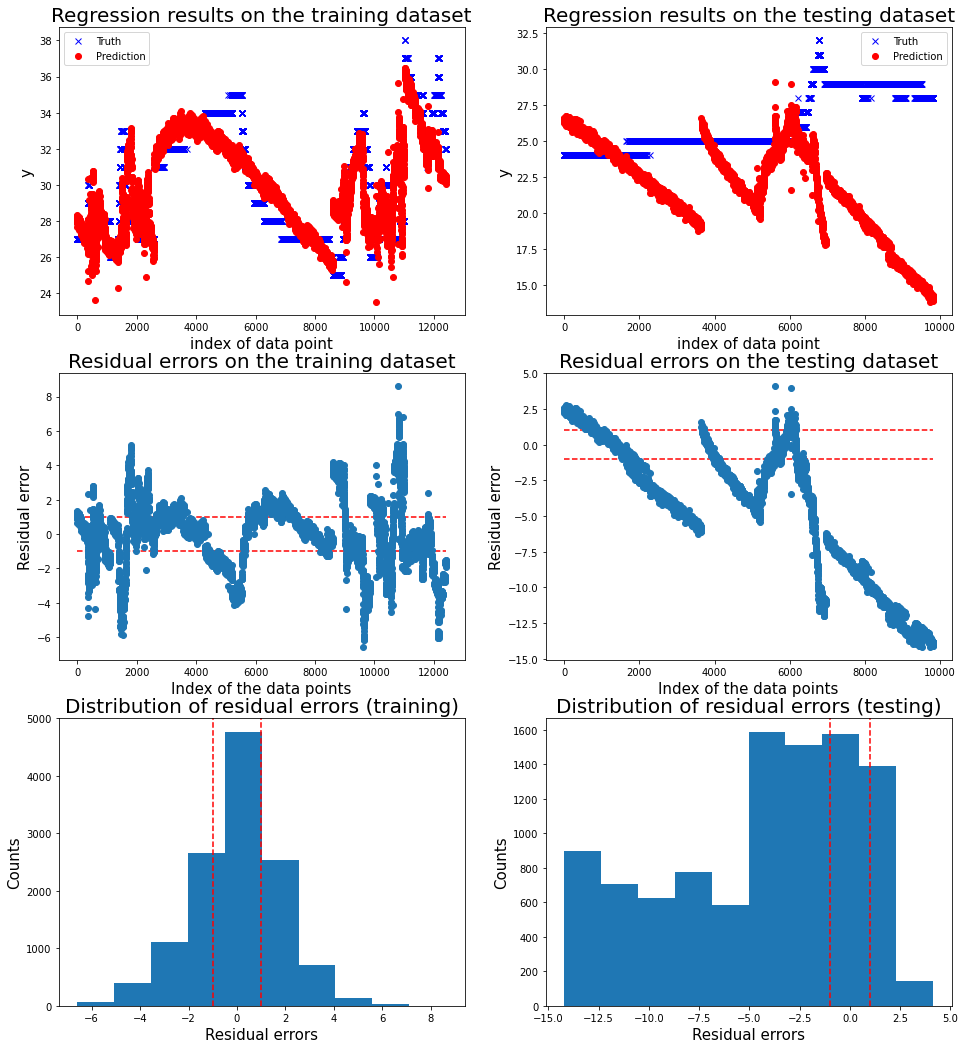


 New run:

training performance, max error is: 9.458808087158658
training performance, mean root square error is: 1.848146573922616
training performance, residual error > 1: 64.2623572342543%

 New run:

testing performance, max error is: 14.916204534630337
testing performance, mean root square error is: 5.523604893885902
testing performance, residual error > 1: 99.55277280858677%


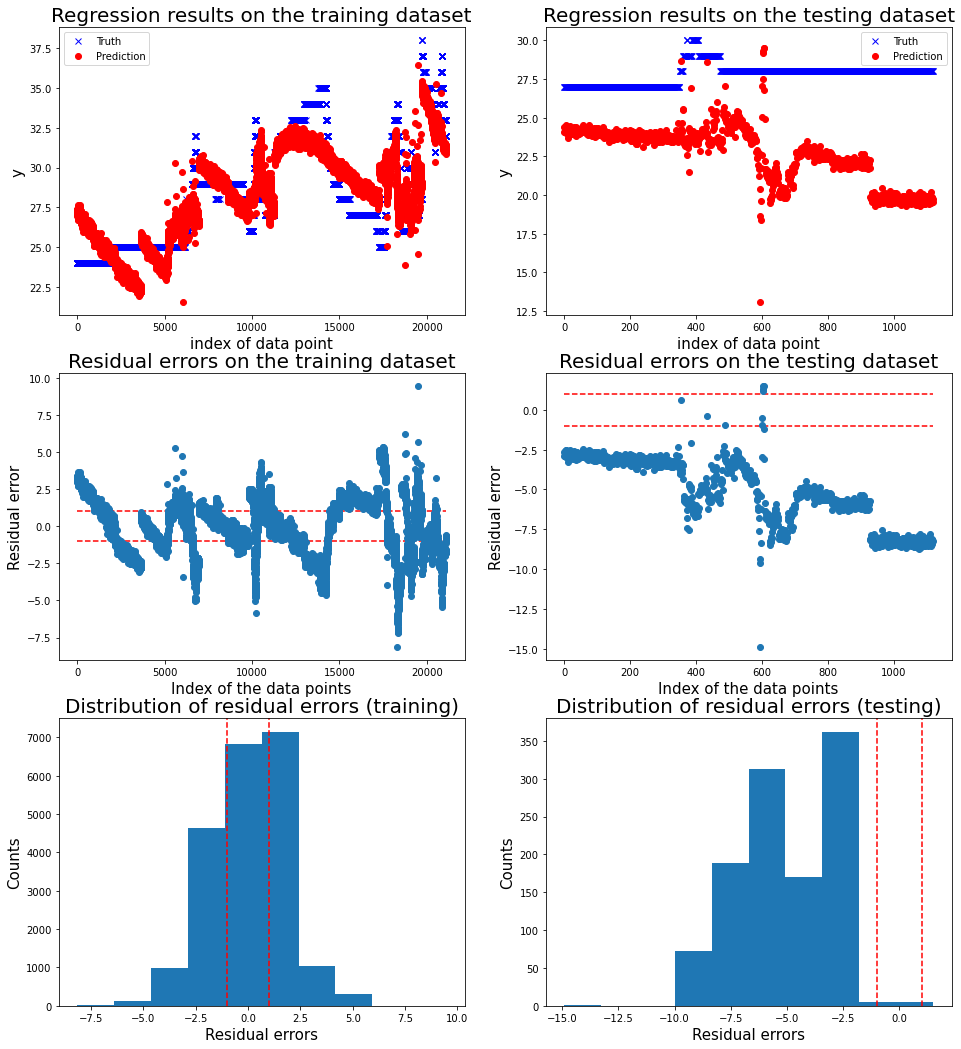


 New run:

training performance, max error is: 7.179838125988923
training performance, mean root square error is: 1.3962605079065815
training performance, residual error > 1: 27.643482129615897%

 New run:

testing performance, max error is: 8.129535141505013
testing performance, mean root square error is: 4.2272877757948635
testing performance, residual error > 1: 63.23142104660483%


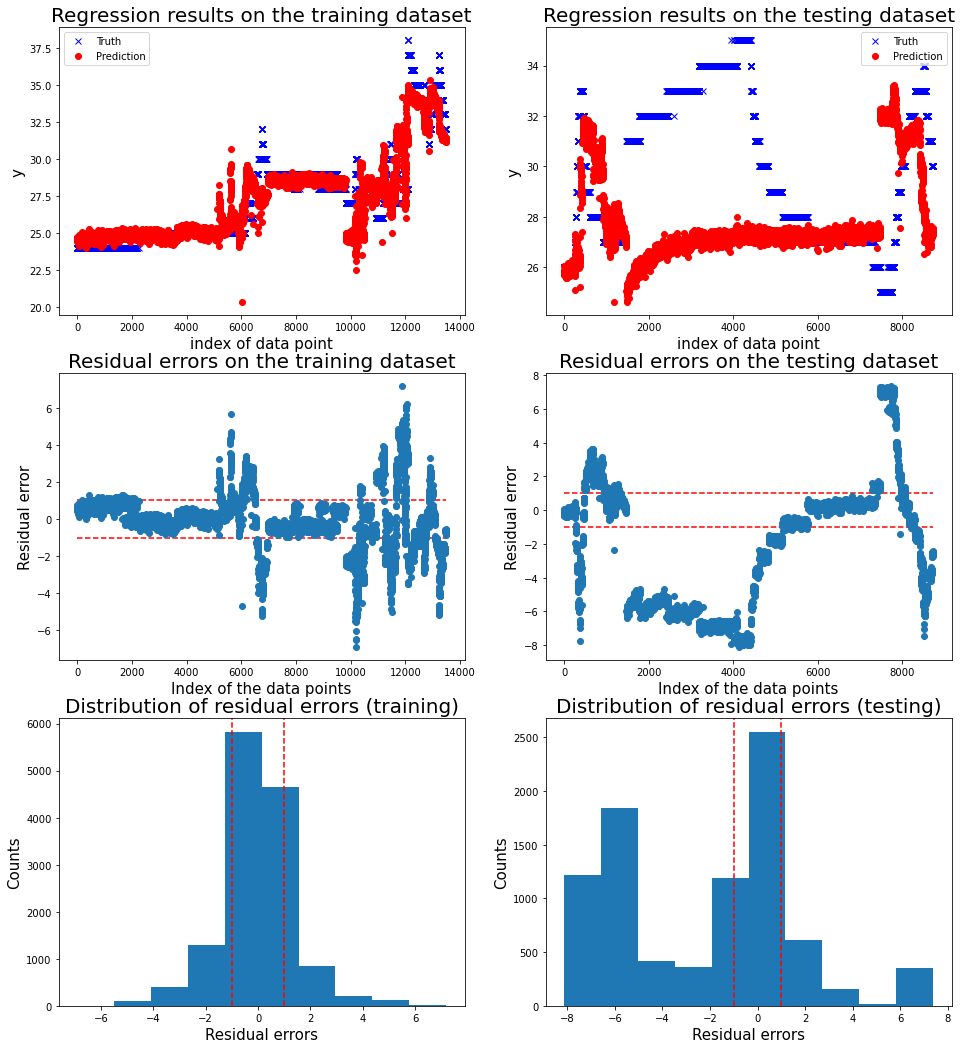


 New run:

training performance, max error is: 10.231472761353018
training performance, mean root square error is: 1.821861814828339
training performance, residual error > 1: 63.29208498715854%

 New run:

testing performance, max error is: 11.186460812677502
testing performance, mean root square error is: 5.163097546803053
testing performance, residual error > 1: 83.83084577114428%


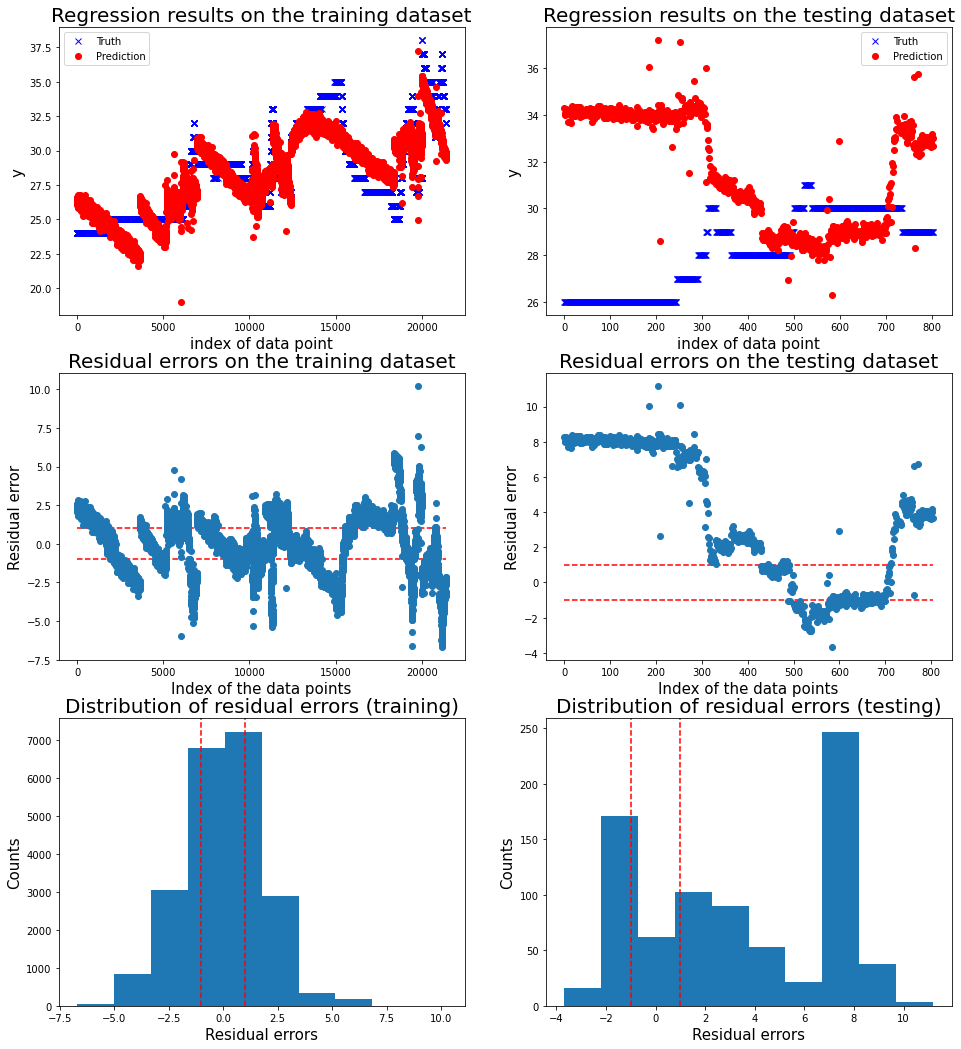


 New run:

training performance, max error is: 8.43428058710056
training performance, mean root square error is: 1.7891514892411922
training performance, residual error > 1: 60.124108277142575%

 New run:

testing performance, max error is: 9.631485791126988
testing performance, mean root square error is: 5.1751367838943345
testing performance, residual error > 1: 87.73531089560753%


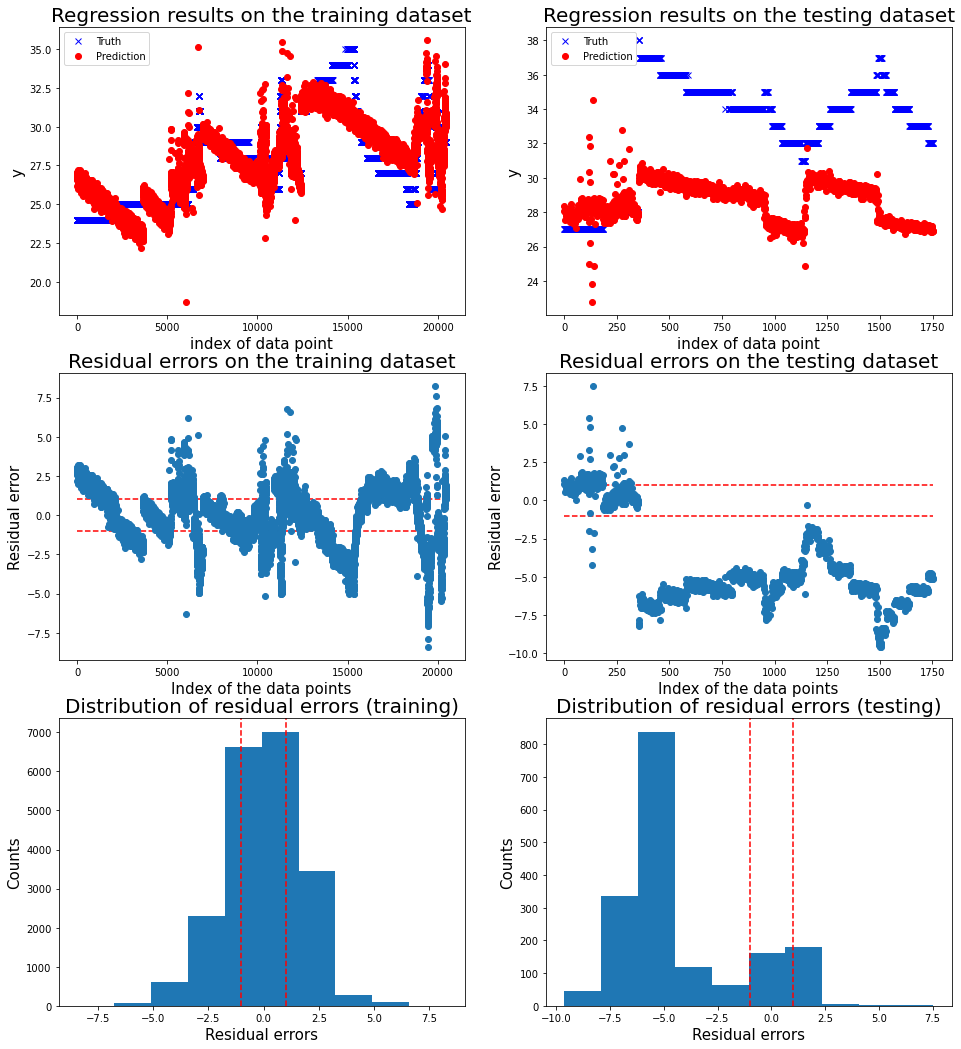

   Max error      RMSE  Exceed boundary rate
0  14.209864  6.503249              0.818775
1  14.916205  5.523605              0.995528
2   8.129535  4.227288              0.632314
3  11.186461  5.163098              0.838308
4   9.631486  5.175137              0.877353


Mean performance metric and standard error:
Max error: 11.6147 +- 2.9111
RMSE: 5.3185 +- 0.8187
Exceed boundary rate: 0.8325 +- 0.1312




In [6]:
from utility import run_cv_one_motor

feature_list_all = ['time', 'data_motor_1_position', 'data_motor_1_temperature', 'data_motor_1_voltage',
                    'data_motor_2_position', 'data_motor_2_temperature', 'data_motor_2_voltage',
                    'data_motor_3_position', 'data_motor_3_temperature', 'data_motor_3_voltage',
                    'data_motor_4_position', 'data_motor_4_temperature', 'data_motor_4_voltage',
                    'data_motor_5_position', 'data_motor_5_temperature', 'data_motor_5_voltage',
                    'data_motor_6_position', 'data_motor_6_temperature', 'data_motor_6_voltage']

threshold = 1
window_size = 1
sample_step = 1

df_perf = run_cv_one_motor(motor_idx=6, df_data=df_data, mdl=mdl_linear_regreession, 
            feature_list=feature_list_all, n_fold=5, 
            threshold=threshold, window_size=window_size, sample_step=sample_step, mdl_type='reg')

**Summary of the results - Only using features from the current moment**

Please add a table in the end, summarying the results from all the models. Please write a few texts to explain what is the best model you got (including the features and preprocessing you did), its performance, and how could you further improve it.

| Model   | Max error | MRSE | Exceed boundary rate |
|---------|----------|-----------|--------|
| Model 1 |   XX.X%  |   XX.X%   |  XX.X% | 
| Model 2 |   XX.X%  |   XX.X%   |  XX.X% | 
| Model 3 |   XX.X%  |   XX.X%   |  XX.X% | 

## Sub-task 2: Include the features in the past

Now, let's consider using the sliding window approach to include the past in the regression model as well. Please have a look at the demo notebook, run your experiment, and report the best models you could have if you apply the sliding window approach.

In [1]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, max_error
from utility import read_all_test_data_from_path, remove_outliers

# Define the sliding window function
def prepare_sliding_window(df, window_size, feature_list):
    df_windowed = pd.DataFrame()
    for i in range(window_size, len(df)):
        window_data = df[feature_list].iloc[i-window_size:i].values.flatten()
        df_windowed = df_windowed.append(pd.Series(window_data), ignore_index=True)
    return df_windowed

# Define parameters for the sliding window
window_size = 5
feature_list_all = [
    'time', 'data_motor_1_position', 'data_motor_1_temperature', 'data_motor_1_voltage',
    'data_motor_2_position', 'data_motor_2_temperature', 'data_motor_2_voltage',
    'data_motor_3_position', 'data_motor_3_temperature', 'data_motor_3_voltage',
    'data_motor_4_position', 'data_motor_4_temperature', 'data_motor_4_voltage',
    'data_motor_5_position', 'data_motor_5_temperature', 'data_motor_5_voltage',
    'data_motor_6_position', 'data_motor_6_temperature', 'data_motor_6_voltage'
]

# Read and preprocess the data
base_dictionary = '../dataset/training_data/'  # Update this with your actual data path
df_data = read_all_test_data_from_path(base_dictionary, remove_outliers, is_plot=False)
df_data_smoothing = df_data.copy()  # Apply smoothing here if necessary

# Prepare sliding window data
df_data_windowed = prepare_sliding_window(df_data, window_size, feature_list_all)
df_data_smoothing_windowed = prepare_sliding_window(df_data_smoothing, window_size, feature_list_all)

# Prepare target variable (adjusted for the sliding window)
target_column = 'data_motor_6_temperature'
y = df_data[target_column][window_size:].reset_index(drop=True)

# Define the cross-validation scheme
kf = KFold(n_splits=5)

# Initialize lists to store performance metrics
max_errors = []
rmses = []
out_of_boundary_rates = []

# Perform cross-validation
for train_index, test_index in kf.split(df_data_windowed):
    X_train, X_test = df_data_windowed.iloc[train_index], df_data_windowed.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Create the pipeline
    mdl_linear_regreession = Pipeline([
        ('standardizer', StandardScaler()),
        ('regressor', LinearRegression())
    ])
    
    # Train the model
    mdl_linear_regreession.fit(X_train, y_train)
    
    # Make predictions
    y_pred = mdl_linear_regreession.predict(X_test)
    
    # Calculate performance metrics
    max_errors.append(max_error(y_test, y_pred))
    rmses.append(mean_squared_error(y_test, y_pred, squared=False))
    out_of_boundary_rate = sum(abs(y_test - y_pred) > 3) / len(y_test)
    out_of_boundary_rates.append(out_of_boundary_rate)

# Calculate mean performance metrics
mean_max_error = np.mean(max_errors)
mean_rmse = np.mean(rmses)
mean_out_of_boundary_rate = np.mean(out_of_boundary_rates)

# Print results
print(f'Max Error: {mean_max_error:.4f}')
print(f'RMSE: {mean_rmse:.4f}')
print(f'Out of Boundary Rate: {mean_out_of_boundary_rate:.4f}')

ImportError: cannot import name 'remove_outliers' from 'utility' (/Users/giovanni/Documents/GitHub/Group_3/projects/maintenance_industry_4_2024/ws_group_3/deliverables/WP_3_20240521/utility.py)

**Summary of the results - Sliding window**

Please add a table in the end, summarying the results from all the models. Please write a few texts to explain what is the best model you got (including the features and preprocessing you did), its performance, and how could you further improve it.

| Model   (also report parameters like window_size, sample_step, prediction_lead_time, etc.) | Max error | MRSE | Exceed boundary rate |
|---------|----------|-----------|--------|
| Model 1 |   XX.X%  |   XX.X%   |  XX.X% | 
| Model 2 |   XX.X%  |   XX.X%   |  XX.X% | 
| Model 3 |   XX.X%  |   XX.X%   |  XX.X% | 

# Task 2 Fault detection based on regression model

In this exercise, we use the dataset that contains the failure of motor 6 to test the fault detection model based on the regression model trained before. 

[This notebook](demo_FaultDetectReg.ipynb) presents a demonstration of how to use the provided supporting function to develop fault detection model based on the regression model. Please have a look at this notebook, and try to improve the performance of the baseline model.

Model for motor 6:


100%|██████████| 1/1 [00:02<00:00,  2.79s/it]



 New run:

testing performance, max error is: 2.6981462157143965
testing performance, mean root square error is: 0.5500023880130339
testing performance, residual error > 1.4952410223516164: 6.036429324100557%

 New run:

testing performance, accuracy is: 0.9637212102965528
testing performance, precision is: 0.9457547169811321
testing performance, recall: 0.6478190630048465
testing performance, F1: 0.7689357622243528




/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


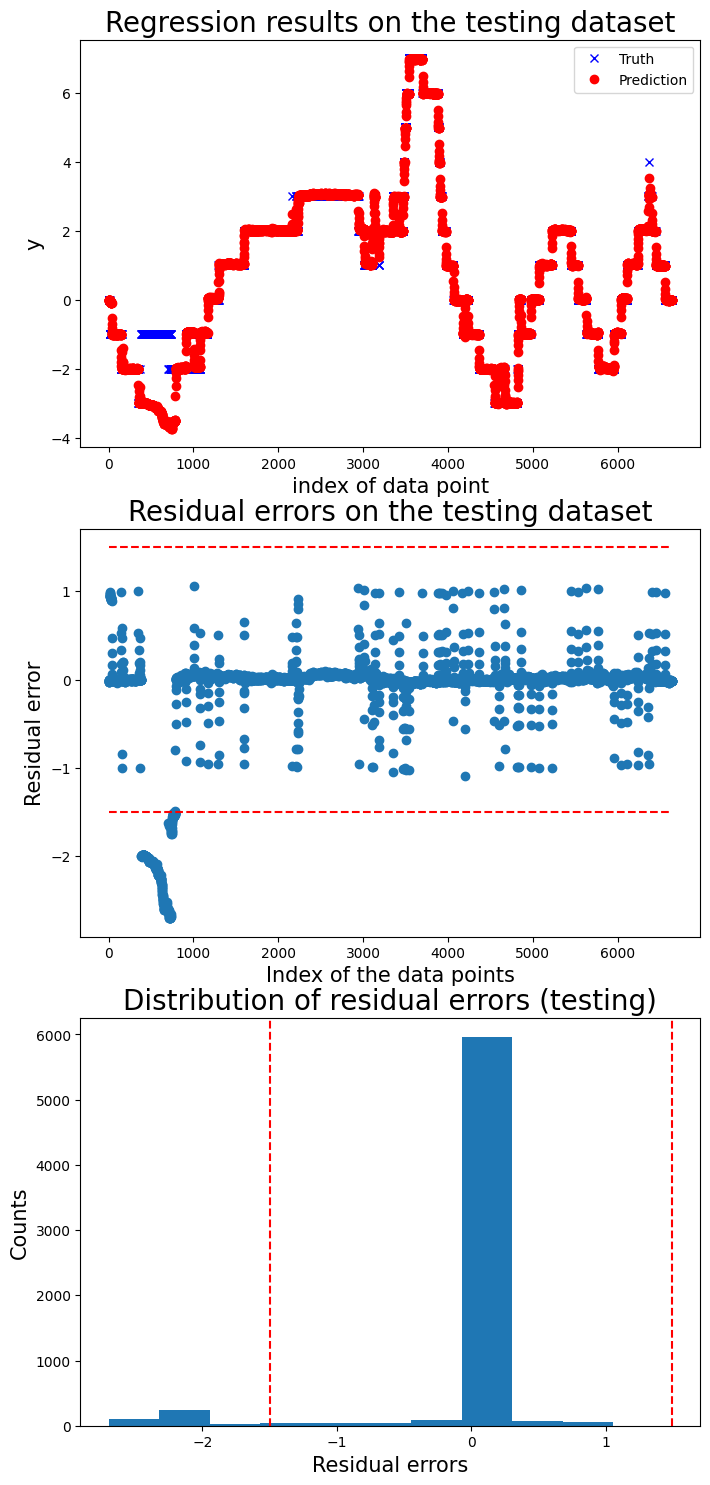

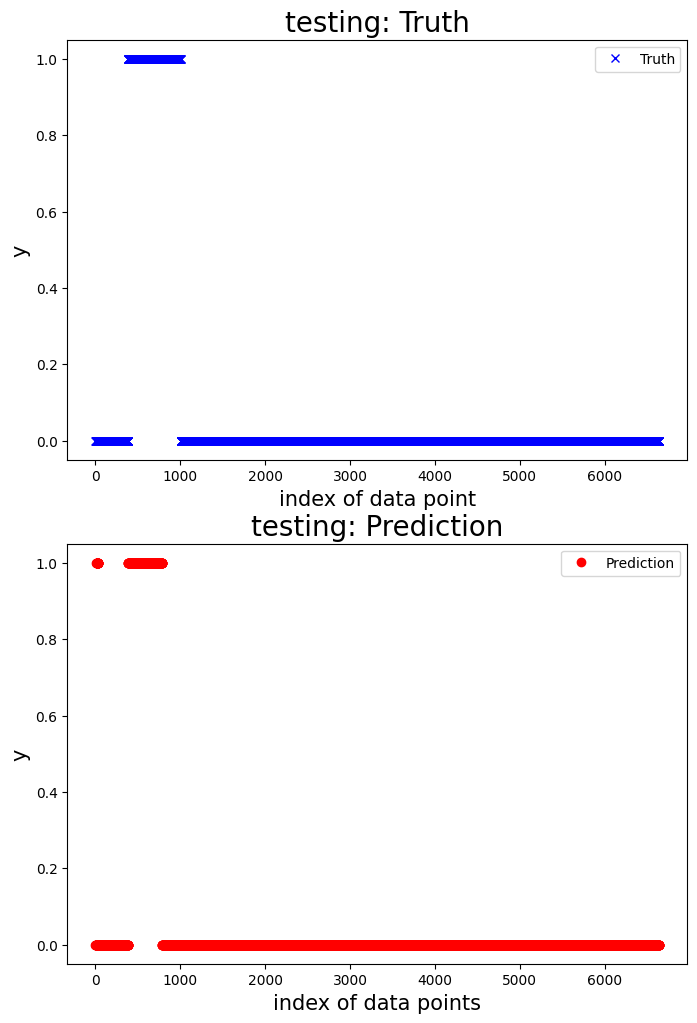

100%|██████████| 1/1 [00:00<00:00, 14.12it/s]
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 New run:

testing performance, max error is: 3.9053297908317024
testing performance, mean root square error is: 1.5449701462054612
testing performance, residual error > 0.9: 42.792792792792795%

 New run:

testing performance, accuracy is: 0.8693693693693694
testing performance, precision is: 0.7789473684210526
testing performance, recall: 0.9024390243902439
testing performance, F1: 0.8361581920903954




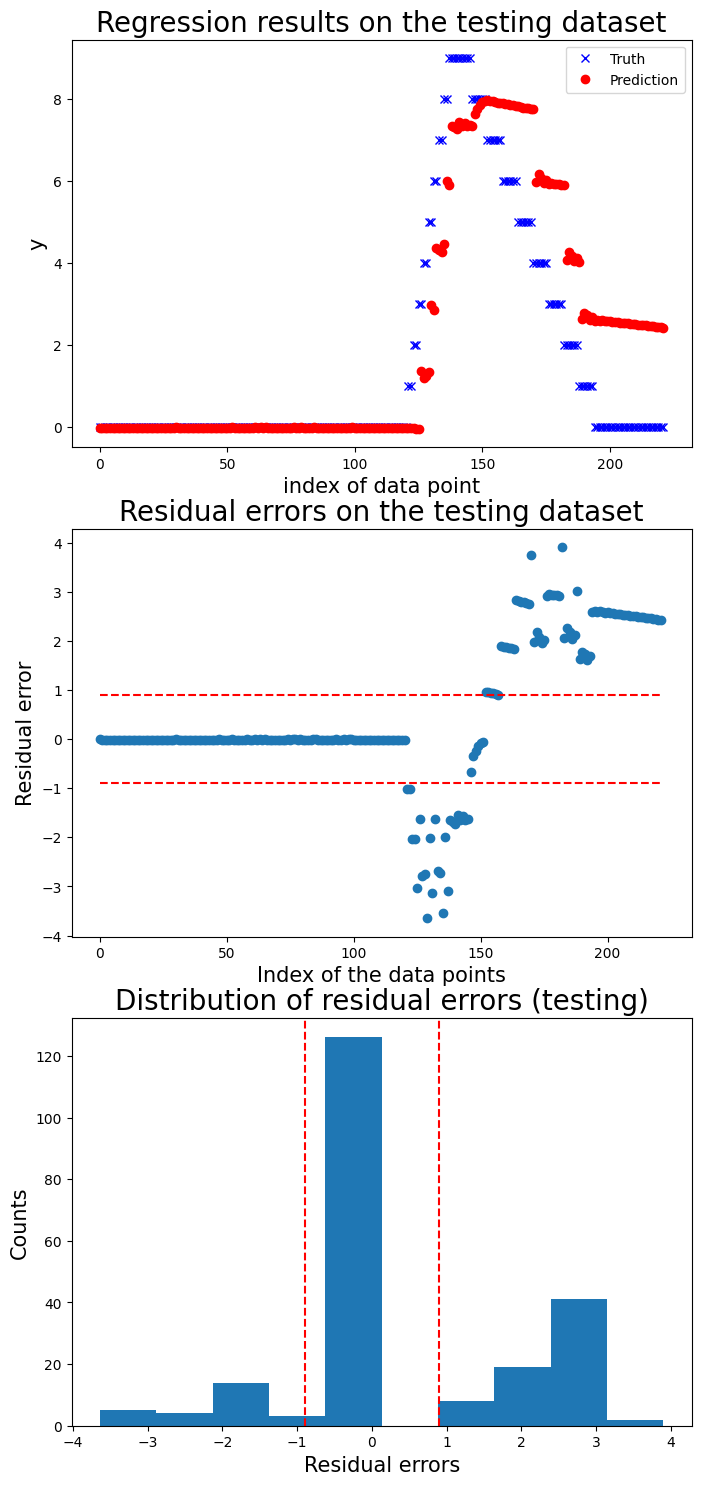

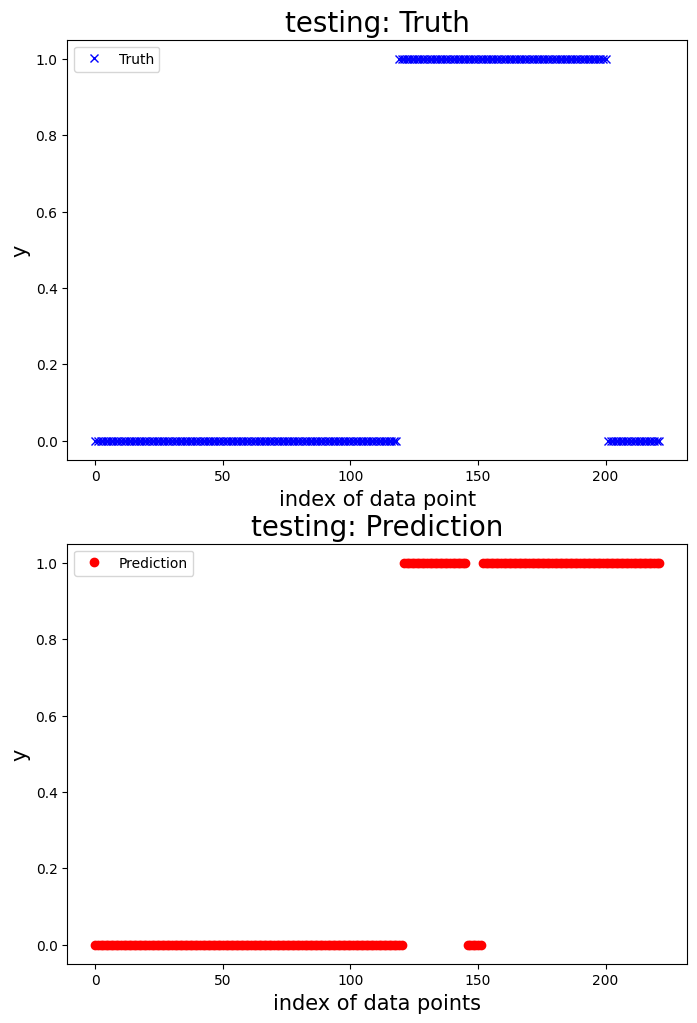

100%|██████████| 1/1 [00:00<00:00,  6.08it/s]
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 New run:

testing performance, max error is: 3.0323285984053245
testing performance, mean root square error is: 0.5470881791963922
testing performance, residual error > 0.9: 19.419237749546276%

 New run:

testing performance, accuracy is: 0.8838475499092558
testing performance, precision is: 0.8037383177570093
testing performance, recall: 0.6666666666666666
testing performance, F1: 0.7288135593220338




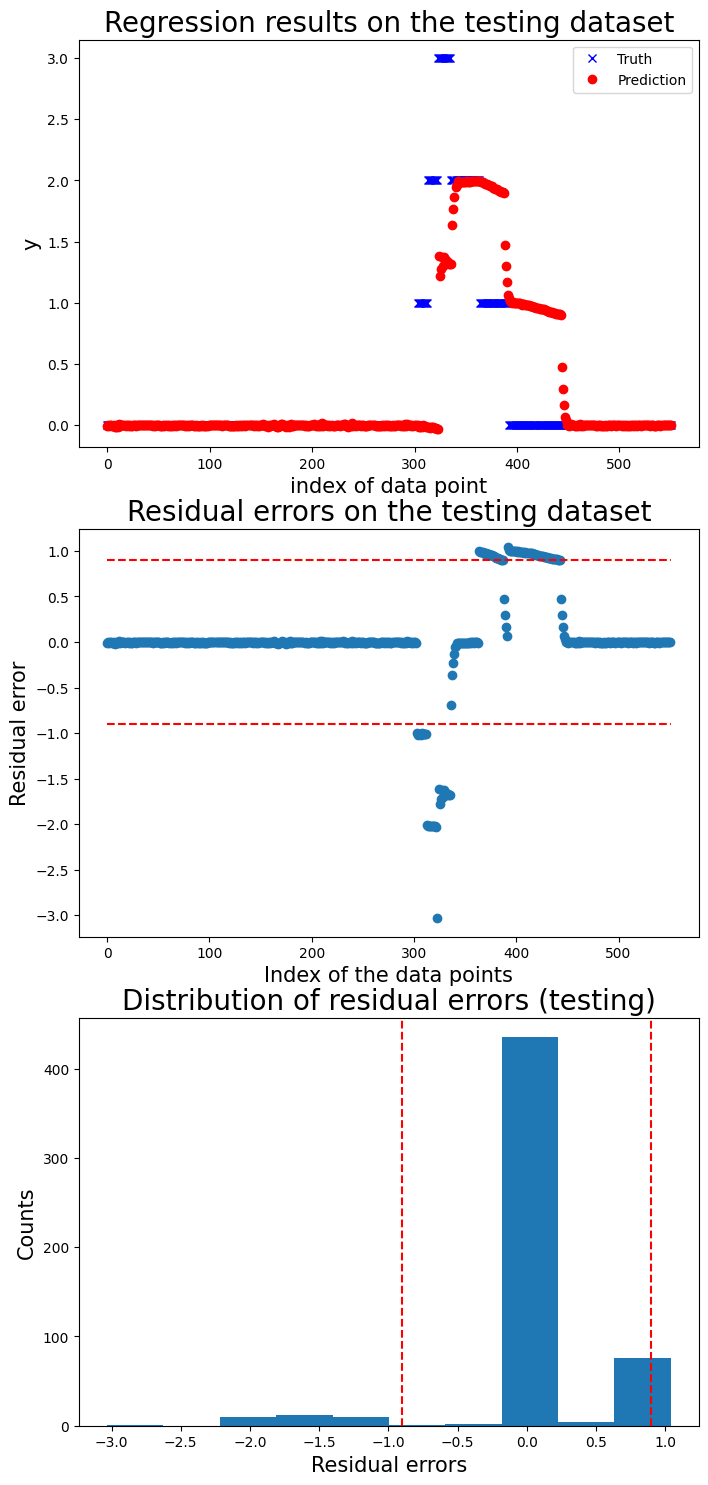

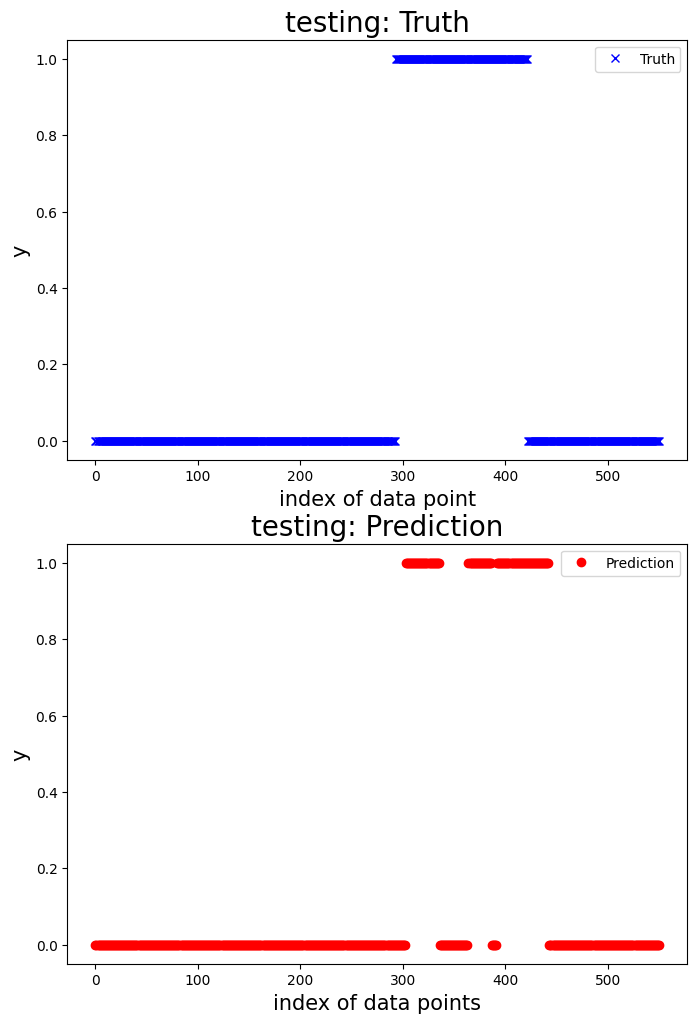

100%|██████████| 1/1 [00:00<00:00,  3.28it/s]



 New run:

testing performance, max error is: 2.039224627693237
testing performance, mean root square error is: 0.2412321536643191
testing performance, residual error > 0.9: 3.3816425120772946%

 New run:

testing performance, accuracy is: 0.9729468599033816
testing performance, precision is: 1.0
testing performance, recall: 0.5555555555555556
testing performance, F1: 0.7142857142857143




/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


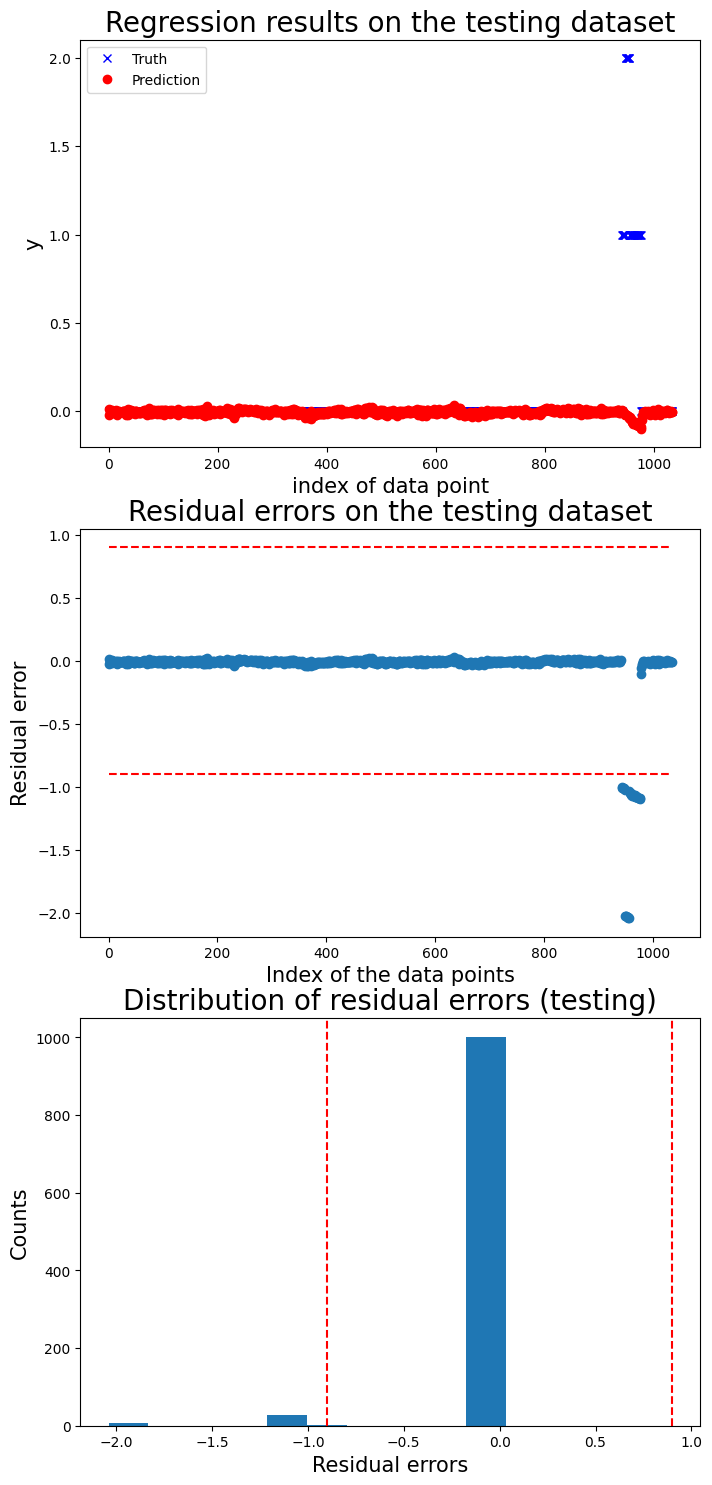

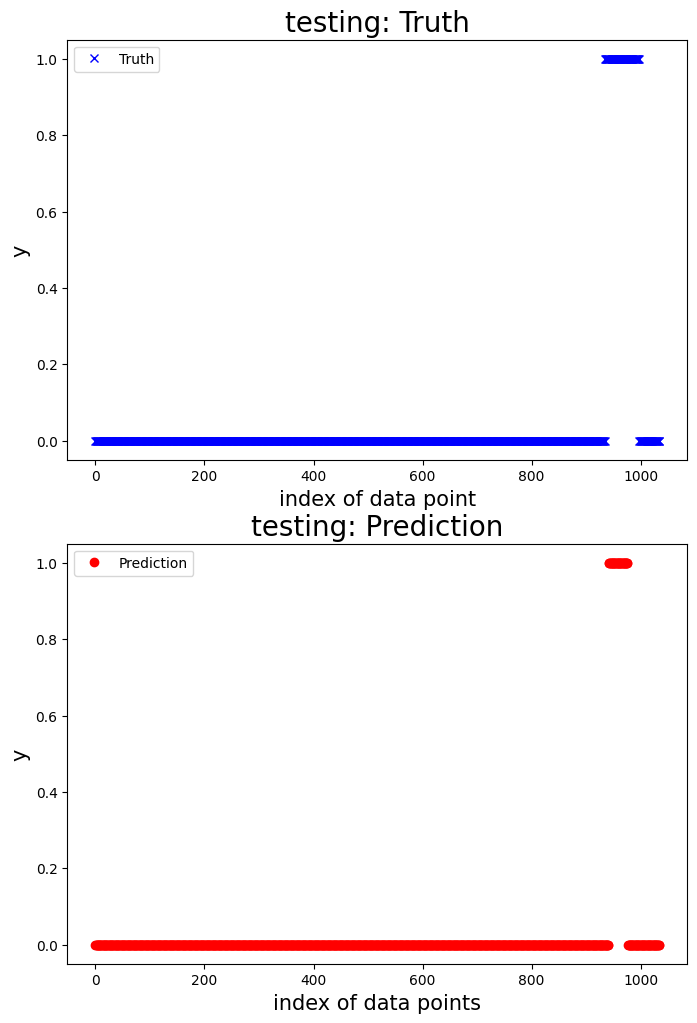

100%|██████████| 1/1 [00:00<00:00,  2.87it/s]



 New run:

testing performance, max error is: 3.9647216733706863
testing performance, mean root square error is: 1.2247309840340046
testing performance, residual error > 0.9: 43.859649122807014%

 New run:

testing performance, accuracy is: 0.8061403508771929
testing performance, precision is: 0.626
testing performance, recall: 0.9020172910662824
testing performance, F1: 0.7390791027154664




/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


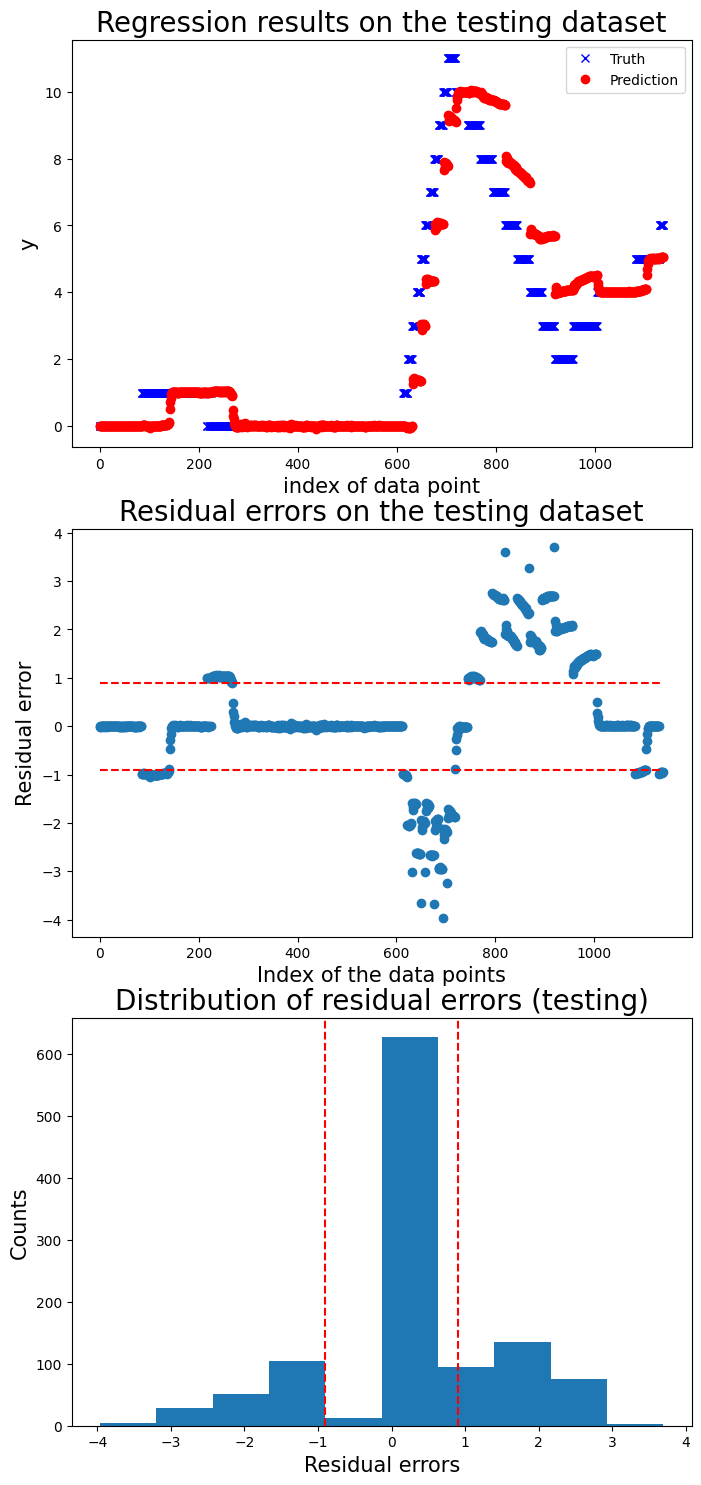

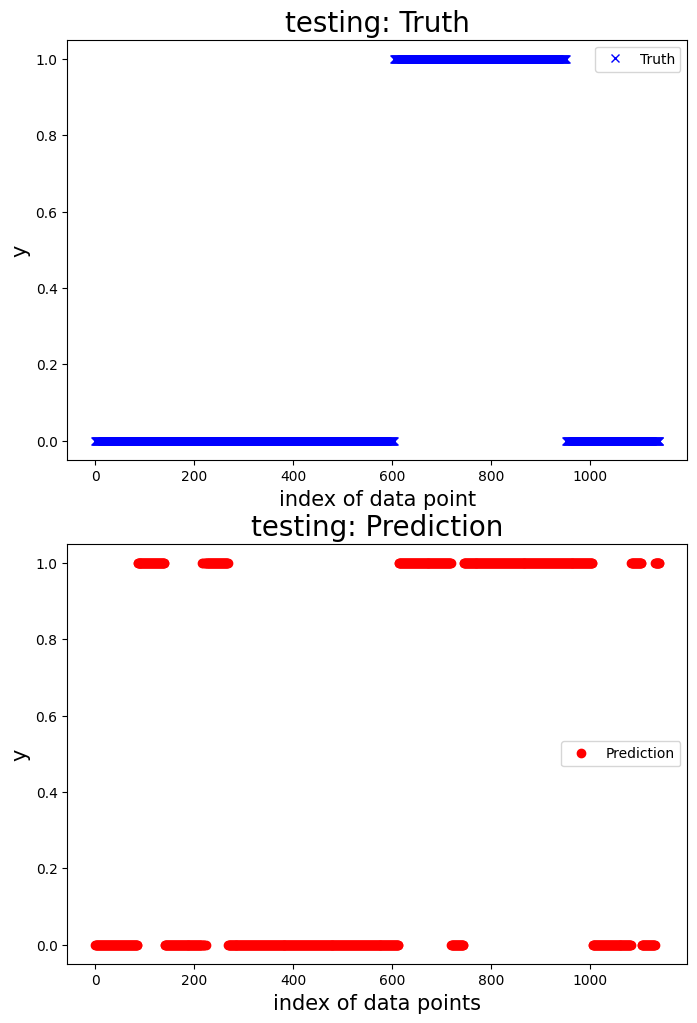

100%|██████████| 1/1 [00:00<00:00,  5.41it/s]
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 New run:

testing performance, max error is: 3.988695590504756
testing performance, mean root square error is: 1.8337589561880412
testing performance, residual error > 0.9: 67.45762711864407%

 New run:

testing performance, accuracy is: 0.7966101694915254
testing performance, precision is: 0.9522613065326633
testing performance, recall: 0.7895833333333333
testing performance, F1: 0.8633257403189066




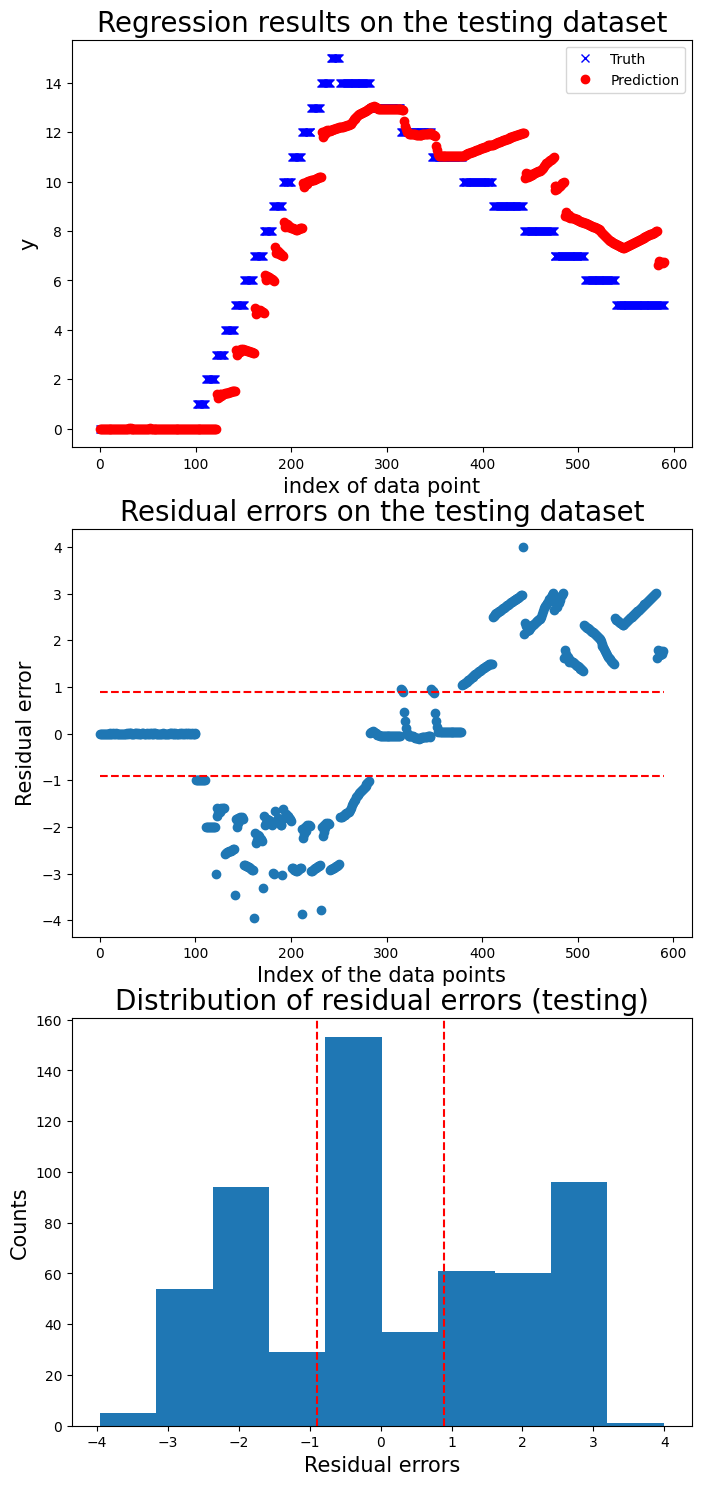

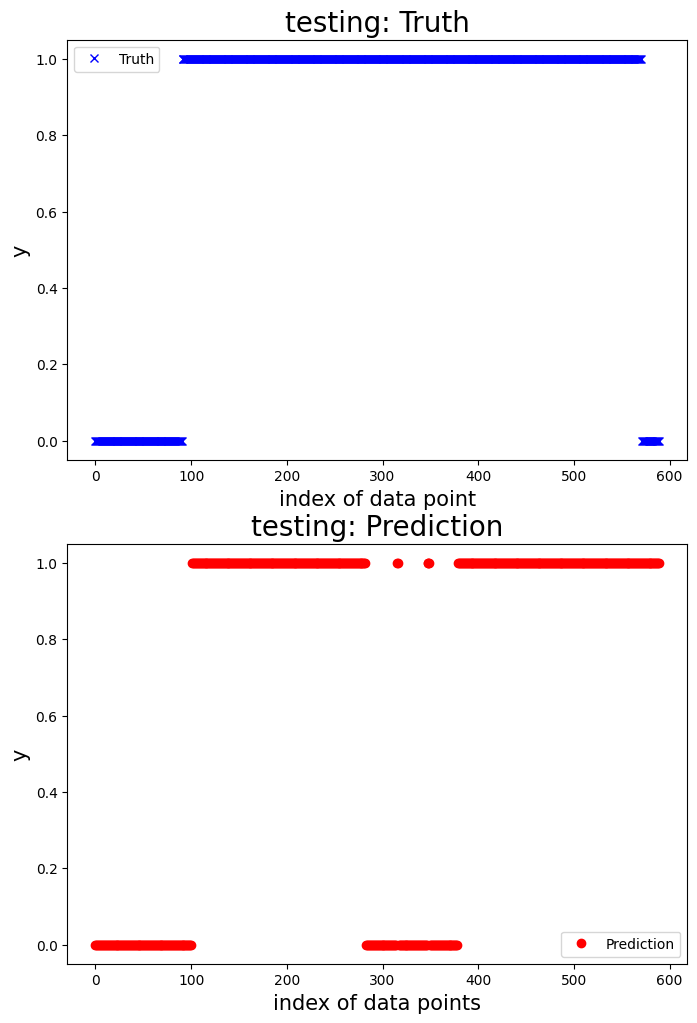

100%|██████████| 1/1 [00:00<00:00,  3.88it/s]



 New run:

testing performance, max error is: 2.9672687761118746
testing performance, mean root square error is: 1.176711189626577
testing performance, residual error > 1.4018126052786375: 19.140625%

 New run:

testing performance, accuracy is: 0.5234375
testing performance, precision is: 0.15
testing performance, recall: 0.15566037735849056
testing performance, F1: 0.1527777777777778




/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


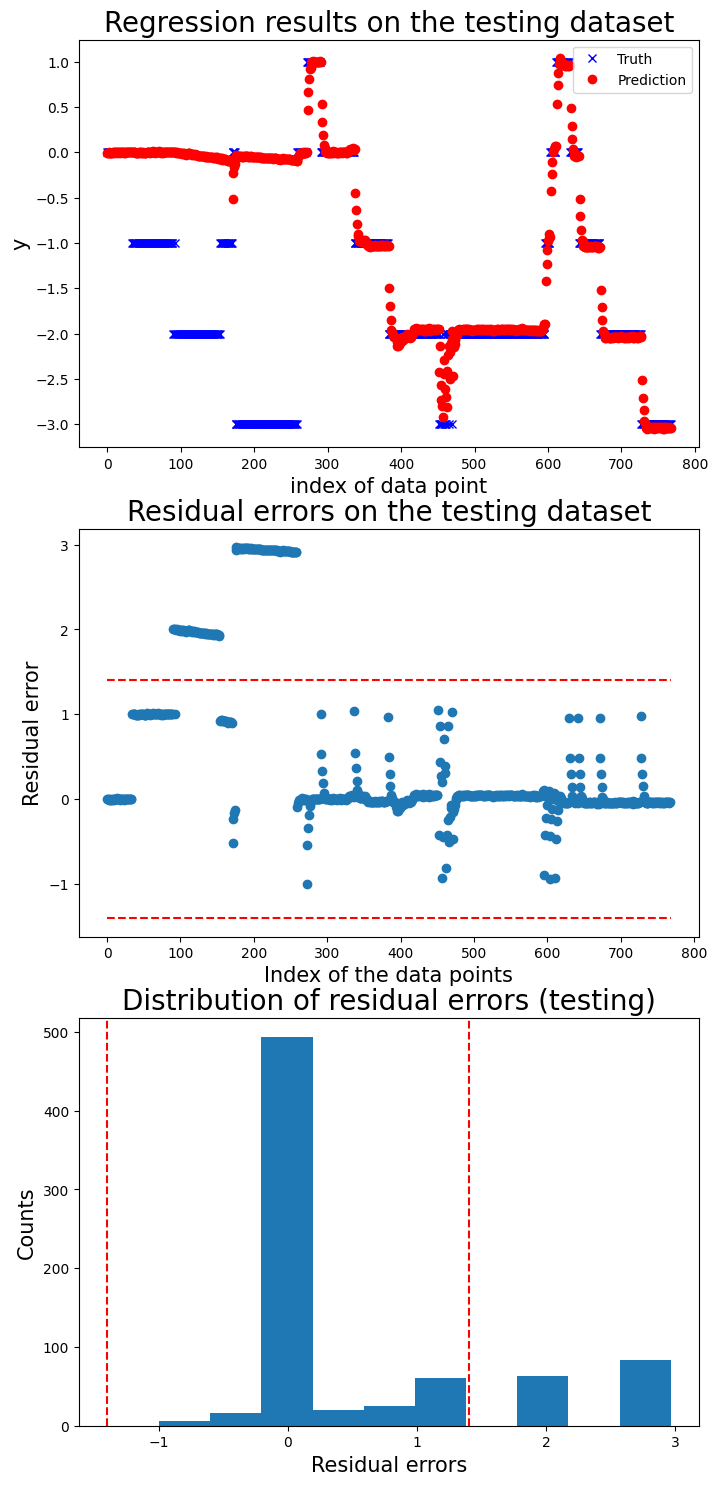

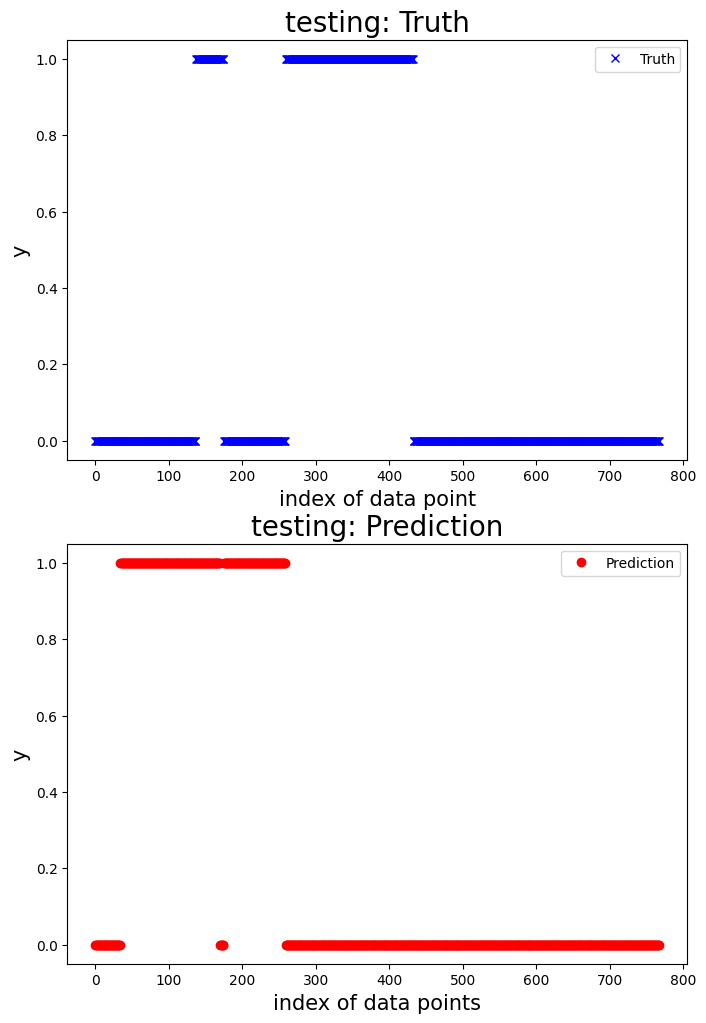

   Accuracy  Precision    Recall  F1 score
0  0.963721   0.945755  0.647819  0.768936
1  0.869369   0.778947  0.902439  0.836158
2  0.883848   0.803738  0.666667  0.728814
3  0.972947   1.000000  0.555556  0.714286
4  0.806140   0.626000  0.902017  0.739079
5  0.796610   0.952261  0.789583  0.863326
6  0.523438   0.150000  0.155660  0.152778


Mean performance metric and standard error:
Accuracy: 0.8309 +- 0.1519
Precision: 0.7510 +- 0.2946
Recall: 0.6600 +- 0.2581
F1 score: 0.6862 +- 0.2417




In [8]:
# Your code here:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from utility import read_all_test_data_from_path, extract_selected_feature, prepare_sliding_window, FaultDetectReg

def remove_outliers(df: pd.DataFrame):
    ''' # Description
    Remove outliers from the dataframe based on defined valid ranges. 
    Define a valid range of temperature and voltage. 
    Use ffil function to replace the invalid measurement with the previous value.
    '''
    df['temperature'] = df['temperature'].where(df['temperature'] <= 100, np.nan)
    df['temperature'] = df['temperature'].where(df['temperature'] >= 0, np.nan)
    df['temperature'] = df['temperature'].ffill()
    df['temperature'] = df['temperature'] - df['temperature'].iloc[0]

    df['voltage'] = df['voltage'].where(df['voltage'] >= 6000, np.nan)
    df['voltage'] = df['voltage'].where(df['voltage'] <= 9000, np.nan)
    df['voltage'] = df['voltage'].ffill()
    df['voltage'] = df['voltage'] - df['voltage'].iloc[0]

    df['position'] = df['position'].where(df['position'] >= 0, np.nan)
    df['position'] = df['position'].where(df['position'] <= 1000, np.nan)
    df['position'] = df['position'].ffill()
    df['position'] = df['position'] - df['position'].iloc[0]


# Read data.
base_dictionary = '../../../dataset/training_data/'
df_data = read_all_test_data_from_path(base_dictionary, remove_outliers, is_plot=False)

# Pre-train the model.
# Get all the normal data.
normal_test_id = ['20240105_164214', 
    '20240105_165300', 
    '20240105_165972', 
    '20240320_152031', 
    '20240320_153841', 
    '20240320_155664', 
    '20240321_122650', 
    '20240325_135213',
    '20240325_152902', 
    '20240426_141190', 
    '20240426_141532', 
    '20240426_141602', 
    '20240426_141726', 
    '20240426_141938', 
    '20240426_141980', 
    '20240503_164435']

df_tr = df_data[df_data['test_condition'].isin(normal_test_id)]

feature_list_all = ['data_motor_1_position', 'data_motor_1_temperature', 'data_motor_1_voltage',
                'data_motor_2_position', 'data_motor_2_temperature', 'data_motor_2_voltage',
                'data_motor_3_position', 'data_motor_3_temperature', 'data_motor_3_voltage',
                'data_motor_4_position', 'data_motor_4_temperature', 'data_motor_4_voltage',
                'data_motor_5_position', 'data_motor_5_temperature', 'data_motor_5_voltage',
                'data_motor_6_position', 'data_motor_6_temperature', 'data_motor_6_voltage']

# feature_list_all = ['time', 'data_motor_1_position', 
#                 'data_motor_2_position', 
#                 'data_motor_3_position', 
#                 'data_motor_4_position', 
#                 'data_motor_5_position', 
#                 'data_motor_6_position', 'data_motor_6_temperature']

# Prepare feature and response of the training dataset.
x_tr_org, y_temp_tr_org = extract_selected_feature(df_data=df_tr, feature_list=feature_list_all, motor_idx=6, mdl_type='reg')

# Enrich the features based on the sliding window.
window_size = 10
sample_step = 1
prediction_lead_time = 1 
threshold = .9
abnormal_limit = 3

x_tr, y_temp_tr = prepare_sliding_window(df_x=x_tr_org, y=y_temp_tr_org, window_size=window_size, sample_step=sample_step, prediction_lead_time=prediction_lead_time, mdl_type='reg')

# Define the steps of the pipeline
steps = [
    ('standardizer', RobustScaler()),  # Step 1: RobustScaler
    ('regressor', RandomForestRegressor())    # Step 2: Random Forest Regression
]

# Create the pipeline
mdl_linear_regreession = Pipeline(steps)

# Hyperparameter tuning
param_grid = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10]
}



# Test data.
test_id = [
    '20240325_155003',
    '20240425_093699',
    '20240425_094425',
    '20240426_140055',
    '20240503_163963',
    '20240503_164675',
    '20240503_165189'
]
df_test = df_data[df_data['test_condition'].isin(test_id)]

# Define the fault detector.
detector_reg = FaultDetectReg(reg_mdl=mdl, threshold=threshold, abnormal_limit=abnormal_limit, window_size=window_size, sample_step=sample_step, pred_lead_time=prediction_lead_time)

# # Run cross validation
n_fold = 7
_, y_label_test_org = extract_selected_feature(df_data=df_test, feature_list=feature_list_all, motor_idx=6, mdl_type='clf')
x_test_org, y_temp_test_org = extract_selected_feature(df_data=df_test, feature_list=feature_list_all, motor_idx=6, mdl_type='reg')

motor_idx = 6
print(f'Model for motor {motor_idx}:')
# Run cross validation.
df_perf = detector_reg.run_cross_val(df_x=x_test_org, y_label=y_label_test_org, y_response=y_temp_test_org, 
                                        n_fold=n_fold)
print(df_perf)
print('\n')
# Print the mean performance and standard error.
print('Mean performance metric and standard error:')
for name, metric, error in zip(df_perf.columns, df_perf.mean(), df_perf.std()):
    print(f'{name}: {metric:.4f} +- {error:.4f}') 
print('\n')

The changes made to imrpove the results of the fault detection model include changing StandardScaler to RobustScaler to better handle outliers and replacing Linear Regression with Random Forest Regression for better performance.



## Summary of the results

Please add a table in the end, summarying the results from all the models (including the unsupervised learning models). Please write a few texts to explain what is the best model you got (including key parameters like threshold, window_size, sample_step, prediction_lead_time, etc), its performance, and how could you further improve it.

| Model   | Accuracy | Precision | Recall | F1   |
|---------|----------|-----------|--------|------|
| Model 1 |   XX.X%  |   XX.X%   |  XX.X% | XX.X%|
| Model 2 |   XX.X%  |   XX.X%   |  XX.X% | XX.X%|
| Model 3 |   XX.X%  |   XX.X%   |  XX.X% | XX.X%|
